In [1]:
MAX_TIME = 1
INIT_SIZE = 10
K = 1

In [2]:
import pickle
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '10-sklearn' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(K) + "K_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
experiment_name

'10-sklearn_bartz09_1min_10init_1K_2023-04-21_11-20-29'

# Chapter 10: Sequential Parameter Optimization
## Hyperparameter Tuning: sklearn decision tree with Rergeression Data 

* This notebook exemplifies hyperparameter tuning with SPOT (spotPython).
* The hyperparameter software SPOT was developed in R (statistical programming language), see Open Access book "Hyperparameter Tuning for Machine and Deep Learning with R - A Practical Guide", available here: [https://link.springer.com/book/10.1007/978-981-19-5170-1](https://link.springer.com/book/10.1007/978-981-19-5170-1).


In [3]:
pip list | grep  "spot[RiverPython]"

spotPython                                0.0.36
spotRiver                                 0.0.91
Note: you may need to restart the kernel to use updated packages.


In [4]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython


## Example 1: HATR Hyperparameter

In [5]:
from tabulate import tabulate
import copy
import warnings
import numbers
import json
import calendar
import math
import datetime as dt
import numpy as np
from math import inf
import pandas as pd

from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt

from spotPython.spot import spot
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    convert_keys,
    get_bound_values,
    get_default_hyperparameters_for_core_model,
    get_default_hyperparameters_for_fun,
    get_default_values,
    get_dict_with_levels_and_types,
    get_values_from_dict,
    get_var_name,
    get_var_type,
    iterate_dict_values,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    replace_levels_with_positions)
from spotPython.hyperparameters.prepare import (
    transform_hyper_parameter_values,
    get_dict_with_levels_and_types,
    convert_keys,
    iterate_dict_values,
)

from spotPython.utils.convert import class_for_name
from spotPython.utils.eda import (
    get_stars,
    gen_design_table)
from spotPython.utils.transform import transform_hyper_parameter_values

from spotPython.data.sklearn_hyper_dict import SklearnHyperDict
from spotPython.fun.hypersklearn import HyperSklearn

from sklearn.preprocessing import OneHotEncoder , MinMaxScaler, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline , Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV

warnings.filterwarnings("ignore")

## 0. Initialization of the Empty `fun_control` Dictionary

In [6]:
fun_control = {}

## 1. Load Data: Random Data

In [7]:
n_samples = 100
target_column = "y"
n_train = 0.6 * n_samples
n_features = 5
# Create a random dataset
X, y = make_regression(n_samples=n_samples, n_features=n_features, noise=1, random_state=42)
# take X and y and make a pandas dataframe with column names X1, X2, y
df = pd.DataFrame(np.hstack((X, y.reshape(-1, 1))))
df.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
# split into train and test
train = df.iloc[:int(n_train), :]
test = df.iloc[int(n_train):, :]

In [8]:
# add the dataset to the fun_control
fun_control.update({"data": None, # dataset,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": target_column})


## 2. Specification of the Preprocessing Model

In [9]:
categorical_columns = []
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
prep_model = ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=StandardScaler(),
    )
fun_control.update({"prep_model": prep_model})

## 3. Select `algorithm` and `core_model_hyper_dict`

In [10]:
core_model  = RidgeCV
fun_control = add_core_model_to_fun_control(core_model=core_model,
                              fun_control=fun_control,
                              hyper_dict=SklearnHyperDict,
                              filename=None)

## 4. Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

### Modify hyperparameter of type factor

In [11]:
# fun_control = modify_hyper_parameter_levels(fun_control, "leaf_model", ["LinearRegression"])
# fun_control["core_model_hyper_dict"]

### Modify hyperparameter of type numeric and integer (boolean)

In [12]:
# fun_control = modify_hyper_parameter_bounds(fun_control, "delta", bounds=[1e-10, 1e-6])
# fun_control = modify_hyper_parameter_bounds(fun_control, "min_samples_split", bounds=[3, 20])
#fun_control = modify_hyper_parameter_bounds(fun_control, "merit_preprune", [0, 0])
fun_control["core_model_hyper_dict"]

{'fit_intercept': {'levels': [0, 1],
  'type': 'factor',
  'default': 1,
  'transform': 'None',
  'core_model_parameter_type': 'bool',
  'lower': 0,
  'upper': 1},
 'gcv_mode': {'levels': ['auto', 'svd', 'eigen'],
  'type': 'factor',
  'default': 'auto',
  'transform': 'None',
  'core_model_parameter_type': 'str',
  'lower': 0,
  'upper': 2},
 'alpha_per_target': {'levels': [0, 1],
  'type': 'factor',
  'default': 0,
  'transform': 'None',
  'core_model_parameter_type': 'bool',
  'lower': 0,
  'upper': 1}}

## 5. Selection of the Objective (Loss) Function

There are two metrics:

    1. `metric` is used for the river based evaluation via `eval_oml_iter_progressive`.
    2. `metric_sklearn` is used for the sklearn based evaluation.

In [13]:
fun = HyperSklearn(seed=123, log_level=50).fun_sklearn
weights = np.array([1, 1/1000, 1/1000])*10_000.0
horizon = 7*24
oml_grace_period = 2
step = 100
weight_coeff = 1.0

fun_control.update({
               "horizon": horizon,
               "oml_grace_period": oml_grace_period,
               "weights": weights,
               "step": step,
               "log_level": 50,
               "weight_coeff": weight_coeff,
               "metric": None,
               "metric_sklearn": mean_absolute_error
               })

## Test Preparation

In [14]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")


from spotPython.hyperparameters.values import (
    assign_values,
)
from spotPython.hyperparameters.prepare import (
    get_one_config_from_var_dict,
)

def check_X_shape(X):
    try:
        X.shape[1]
    except ValueError:
        X = np.array([X])
    if X.shape[1] != len(fun_control["var_name"]):
        raise Exception

def get_Xy_from_df(df, target_column)->tuple:
    X = df.drop(columns=[target_column])
    y = df[target_column]
    return X, y

def evaluate_model(model, fun_control):
    X_train, y_train = get_Xy_from_df(fun_control["train"], fun_control["target_column"])
    try:
        X_train, y_train = get_Xy_from_df(fun_control["train"], fun_control["target_column"])
        X_test, y_test = get_Xy_from_df(fun_control["test"], fun_control["target_column"])
        model.fit(X_train, y_train)
        df_preds = model.predict(X_test)
        df_eval = fun_control["metric_sklearn"](y_test, df_preds)
    except Exception as err:
        print(f"Error in fun_sklearn(). Call to evaluate_model failed. {err=}, {type(err)=}")
        df_eval = np.nan
        df_preds = np.nan
    return df_eval, df_preds

def fun_sklearn(X, fun_control=None, return_model=False, return_df=False):
    z_res = np.array([], dtype=float)
    fun_control.update(fun_control)
    check_X_shape(X)
    var_dict = assign_values(X, fun_control["var_name"])
    for config in get_one_config_from_var_dict(var_dict, fun_control):
        model = make_pipeline(
            fun_control["prep_model"], fun_control["core_model"](**config)
        )
        if return_model:
            return model
        df_eval, df_preds = evaluate_model(model, fun_control)
        if return_df:
            return df_eval, df_preds
        z_res = np.append(z_res, df_eval)
    return z_res

In [15]:
X = get_default_values(fun_control)
X = replace_levels_with_positions(fun_control["core_model_hyper_dict"], X)
X = get_values_from_dict(X)
X = X.reshape(1, -1)
X.shape[1] != len(fun_control["var_name"])

False

In [16]:
fun_sklearn(X, fun_control=fun_control, return_df=False)

array([0.74182049])

## 6. Calling the SPOT Function

### Prepare the SPOT Parameters

* Get types and variable names as well as lower and upper bounds for the hyperparameters.

In [17]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

In [18]:
print(gen_design_table(fun_control))

| name             | type   | default   |   lower |   upper |
|------------------|--------|-----------|---------|---------|
| fit_intercept    | factor | 1         |       0 |       1 |
| gcv_mode         | factor | auto      |       0 |       2 |
| alpha_per_target | factor | 0         |       0 |       1 |


### Run the `Spot` Optimizer

* Run SPOT for approx. x mins (`max_time`).
* Note: the run takes longer, because the evaluation time of initial design (here: `initi_size`, 20 points) is not considered.

In [19]:
spot_sklearn = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_sklearn.run()

spotPython tuning: [##########] 100.00% Done...


### 4 Results

In [21]:
SAVE = True
LOAD = False

if SAVE:
    result_file_name = "res_" + experiment_name + ".pkl"
    with open(result_file_name, 'wb') as f:
        pickle.dump(spot_sklearn, f)

if LOAD:
    result_file_name = "res_ch10-friedman-hpt-0_maans03_60min_20init_1K_2023-04-14_10-11-19.pkl"
    with open(result_file_name, 'rb') as f:
        spot_sklearn =  pickle.load(f)

* Show the Progress of the hyperparameter tuning:

FileNotFoundError: [Errno 2] No such file or directory: '../Figures.d/10-sklearn_bartz09_1min_10init_1K_2023-04-21_11-20-29_progress.pdf'

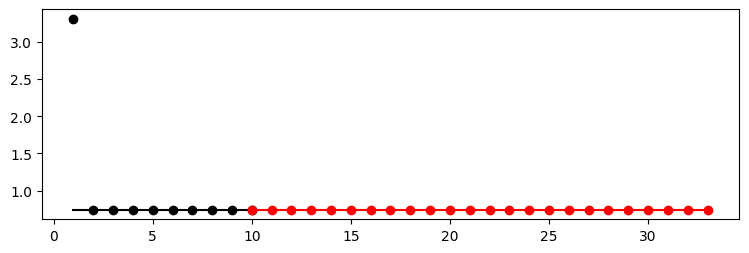

In [23]:
spot_sklearn.plot_progress(log_y=False, filename="../Figures.d/" + experiment_name+"_progress.pdf")



* Print the Results

In [28]:
res = spot_sklearn.print_results(print_screen=False)
print(tabulate(
   res,
   headers=["Parameter", "Value"],
   numalign="right",
   tablefmt="github")
)

| Parameter        |   Value |
|------------------|---------|
| fit_intercept    |       1 |
| gcv_mode         |       1 |
| alpha_per_target |       0 |


## Show variable importance

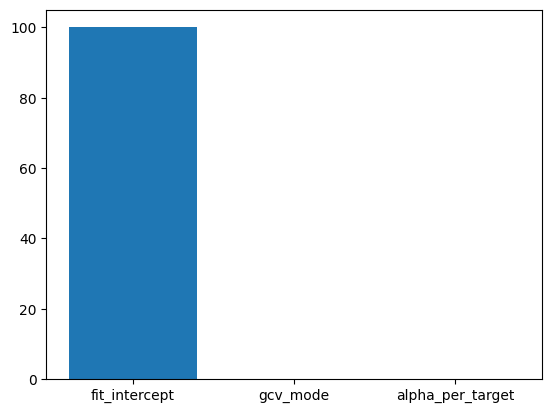

In [35]:
spot_sklearn.plot_importance(threshold=1e-6, filename="../Figures.d/" + experiment_name+"_importance.pdf")

In [36]:
print(gen_design_table(fun_control=fun_control, spot=spot_sklearn))

| name             | type   | default   |   lower |   upper |   tuned |   importance | stars   |
|------------------|--------|-----------|---------|---------|---------|--------------|---------|
| fit_intercept    | factor | 1         |       0 |       1 |     1.0 |       100.00 | ***     |
| gcv_mode         | factor | auto      |       0 |       2 |     1.0 |         0.00 |         |
| alpha_per_target | factor | 0         |       0 |       1 |     0.0 |         0.00 |         |


## Get Default Hyperparameters

In [41]:
values = get_default_hyperparameters_for_core_model(fun_control=fun_control,
                                                   hyper_dict=SklearnHyperDict)
model = make_pipeline(fun_control["prep_model"], fun_control["core_model"](**values))

In [ ]:
from sklearn.model_selection import cross_val_predict

X_test, y_test = self.get_Xy_from_df(fun_control["test"], fun_control["target_column"])

y_pred = cross_val_predict(model, X, y, cv=10)

In [ ]:
df_eval_default, df_true_default = eval_oml_horizon(
                    model=model,
                    train=fun_control["train"],
                    test=fun_control["test"],
                    target_column=fun_control["target_column"],
                    horizon=fun_control["horizon"],
                    oml_grace_period=fun_control["oml_grace_period"],
                    metric=fun_control["metric_sklearn"],
                )

In [ ]:
df_labels=["default"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_default], log_y=False, df_labels=df_labels, metric=metric)
plot_bml_oml_horizon_predictions(df_true = [df_true_default[a:b]], target_column=target_column,  df_labels=df_labels)

## Get SPOT Results

In [ ]:
X = spot_sklearn.to_all_dim(spot_sklearn.min_X.reshape(1,-1))
print(X)


In [ ]:
var_dict = assign_values(X, fun_control["var_name"])
values = get_values_from_var_dict(var_dict, fun_control)
model = compose.Pipeline(fun_control["prep_model"], fun_control["core_model"](**values))

In [ ]:
df_eval_spot, df_true_spot = eval_oml_horizon(
                    model=model,
                    train=fun_control["train"],
                    test=fun_control["test"],
                    target_column=fun_control["target_column"],
                    horizon=fun_control["horizon"],
                    oml_grace_period=fun_control["oml_grace_period"],
                    metric=fun_control["metric_sklearn"],
                )

In [ ]:
df_labels=["default", "spot"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_default, df_eval_spot], log_y=False, df_labels=df_labels, metric=metric, filename="../Figures.d/" + experiment_name+"_metrics.pdf")


In [ ]:
a = int(m/2)+20
b = int(m/2)+50
plot_bml_oml_horizon_predictions(df_true = [df_true_default[a:b], df_true_spot[a:b]], target_column=target_column,  df_labels=df_labels, filename="../Figures.d/" + experiment_name+"_predictions.pdf")

## Visualize Regression Trees

In [ ]:
X0 = get_default_hyperparameters_for_fun(fun_control=fun_control, hyper_dict=RiverHyperDict)
model_default = fun(X0, fun_control, return_model=True)
model_default[1]

In [ ]:
model_default[1].summary

In [ ]:
dataset_f = dataset.take(n_total)
for x, y in dataset_f:
    model_default[1].learn_one(x, y)

In [ ]:
model_default[1].summary

In [ ]:
model_default[1].draw()

### Spot Model

In [ ]:
model_spot = fun(X, fun_control, return_model=True)
model_spot[1]

In [ ]:
dataset_f = dataset.take(n_total)
for x, y in dataset_f:
    model_spot[1].learn_one(x, y)

In [ ]:
model_spot

In [ ]:
model_spot[1].summary

In [ ]:
def compare_two_tree_models(model1, model2, headers=["Parameter", "Default", "Spot"]):
    keys = model1[1].summary.keys()
    values1 = model1[1].summary.values()
    values2 = model2[1].summary.values()
    tbl = []
    for key, value1, value2 in zip(keys, values1, values2):
        tbl.append([key, value1, value2])
    return tabulate(tbl, headers=headers, numalign="right", tablefmt="github")

In [ ]:
print(compare_two_tree_models(model_default, model_spot))

In [ ]:
model_spot[1].draw()

In [ ]:
min(spot_sklearn.y), max(spot_sklearn.y)

## Detailed Hyperparameter Plots

* For productive use, you might want to select:
  * `min_z=min(spot_sklearn.y)` and
  * `max_z = max(spot_sklearn.y)`
* These settings are not so colorful as visualizations that use `None` for the ranges, but give better insights.

fit_intercept:  100.0
gcv_mode:  1.1674573775046825e-05
alpha_per_target:  1.101756336210837e-05


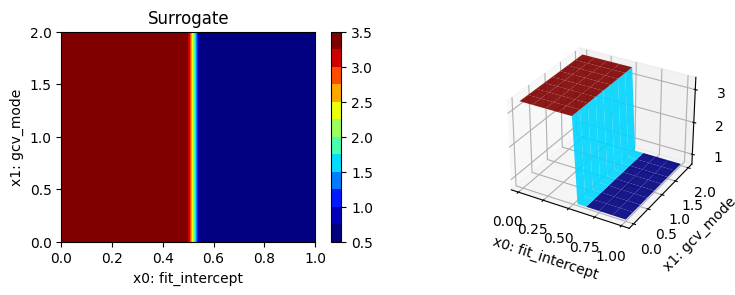

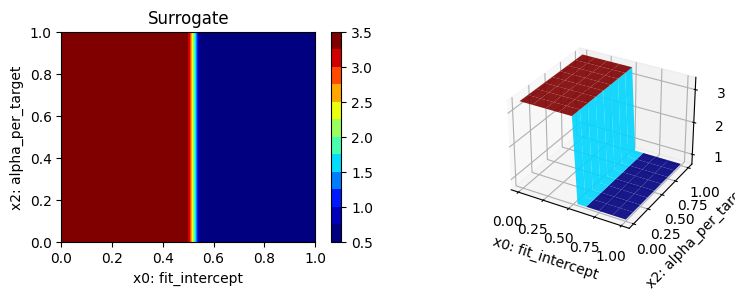

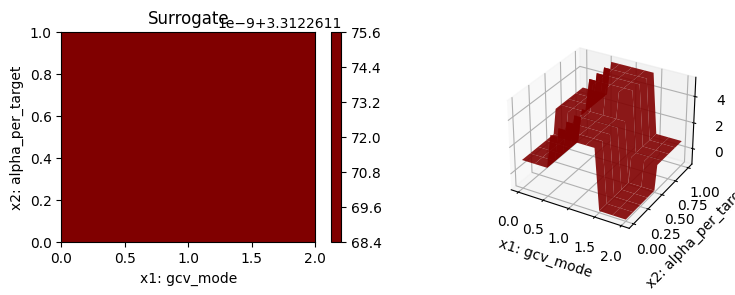

In [38]:
threshold = 1e-6
impo = spot_sklearn.print_importance(threshold=threshold, print_screen=True)
var_plots = [i for i, x in enumerate(impo) if x[1] > threshold]
min_z = min(spot_sklearn.y)
max_z = max(spot_sklearn.y)
n = spot_sklearn.k
for i in var_plots:
    for j in var_plots:
        if j > i:
            filename = "../Figures.d/" + experiment_name+"_contour_"+str(i)+"_"+str(j)+".pdf"
            spot_sklearn.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z, filename=filename)

## Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [34]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_sklearn.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_sklearn.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)